In [35]:
import project.IT_GAN.BigGAN as BigGAN
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
import torchvision.transforms as transforms
from torchvision import datasets
import pathlib


%load_ext autoreload
%autoreload 2
%matplotlib widget


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
exp = 0
dataset = "CIFAR10"
num_classes = 10
device = "cuda"
root_path = pathlib.Path('H:/arty/data/IT-GAN') 
data_path = root_path / 'data' 
checkpoint_path = root_path / 'checkpoints' 
weight_path = checkpoint_path / f"G_Pretrained_CIFAR10_exp{exp}.pth"
dim_z=128
channel = 3
im_size = (32, 32)
num_classes = 10
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
samples_per_class = 5

In [78]:
big_gan = BigGAN.Generator(G_ch=64, dim_z=dim_z, bottom_width=4, resolution=32,
                         G_kernel_size=3, G_attn='0', n_classes=num_classes,
                         num_G_SVs=1, num_G_SV_itrs=1,
                         G_shared=False, shared_dim=0, hier=False,
                         cross_replica=False, mybn=False,
                         G_activation=nn.ReLU(inplace=False),
                         G_lr=2e-4, G_B1=0.0, G_B2=0.999, adam_eps=1e-8,
                         BN_eps=1e-5, SN_eps=1e-08, G_mixed_precision=False, G_fp16=False,
                         G_init='N02', skip_init=False, no_optim=False,
                         G_param='SN', norm_style='bn').to(device)
big_gan.load_state_dict(torch.load(weight_path, map_location=device), strict=True)
big_gan.eval()

mean_GAN = [0.5, 0.5, 0.5]
std_GAN = [0.5, 0.5, 0.5]

def renormalize(img):
    return torch.cat([(((img[:, 0] * std_GAN[0] + mean_GAN[0]) - mean[0]) / std[0]).unsqueeze(1),
                        (((img[:, 1] * std_GAN[1] + mean_GAN[1]) - mean[1]) / std[1]).unsqueeze(1),
                        (((img[:, 2] * std_GAN[2] + mean_GAN[2]) - mean[2]) / std[2]).unsqueeze(1)], dim=1)


def generate(z, lab):
    num_max = 500  # Error occurs when batch size of G is large.
    num = z.shape[0]
    if num > num_max:
        img_syn = []
        for i in range(int(np.ceil(num / num_max))):
            img_syn.append(renormalize(big_gan(z[i * num_max: (i + 1) * num_max], lab[i * num_max: (i + 1) * num_max])))
        return torch.cat(img_syn, dim=0)
    else:
        return renormalize(big_gan(z, lab))

Param count for Gs initialized parameters: 4303875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


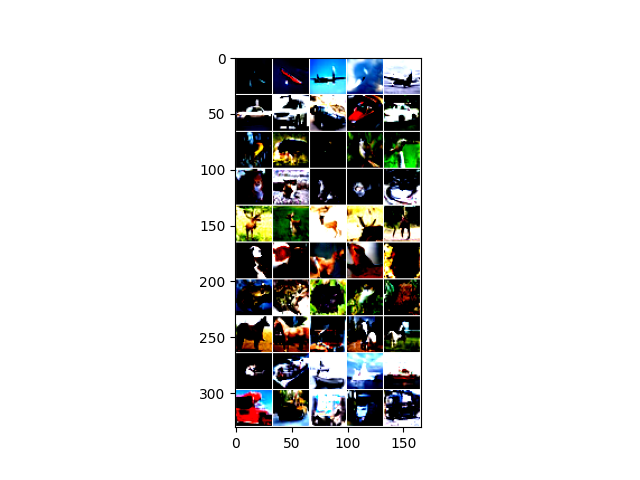

In [79]:
labe = torch.tensor([i for i in range(num_classes) for _ in range(samples_per_class)], dtype=torch.long, device=device)
z = torch.randn(size=(len(labe), dim_z), dtype=torch.float, requires_grad=False, device=device)
imgs = generate(z, labe)
grid_z = torchvision.utils.make_grid(imgs, nrow=samples_per_class, padding=1, pad_value=1)
grid_z = grid_z.permute(1, 2, 0).cpu().detach().numpy()
fig, ax = plt.subplots()
ax.imshow(grid_z)


In [67]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform) # no augmentation
labels_all = [dst_train[i][1] for i in range(len(dst_train))]
labels_all = np.array(labels_all)
idxs = np.concatenate([np.where(labels_all == i)[0][:samples_per_class] for i in range(num_classes)])
labels = labels_all[idxs]

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


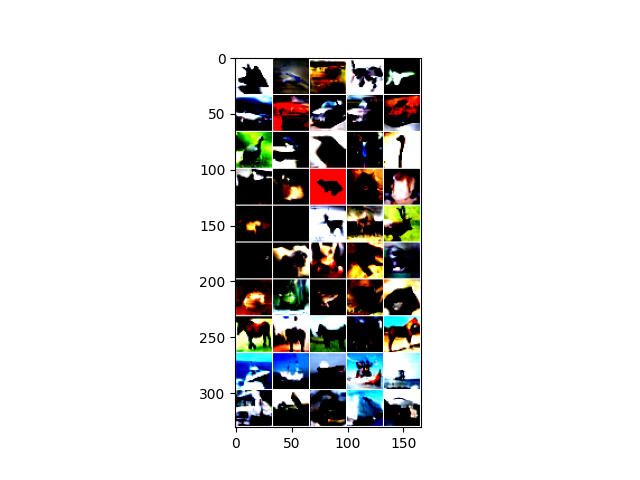

In [80]:
fpath = checkpoint_path / f'GANInversion_final_{dataset}_ConvNet_lrz0.100_exp{exp}.pt'
data_z = torch.load(fpath, map_location=device)
z_inverse = data_z['z_inverse_all'].clone().detach()[idxs]
imgs_inverse = generate(z_inverse, labe)
grid_inv = torchvision.utils.make_grid(imgs_inverse, nrow=samples_per_class, padding=1, pad_value=1)
grid_inv = grid_inv.permute(1, 2, 0).cpu().detach().numpy()
fig, ax = plt.subplots()
ax.imshow(grid_inv)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


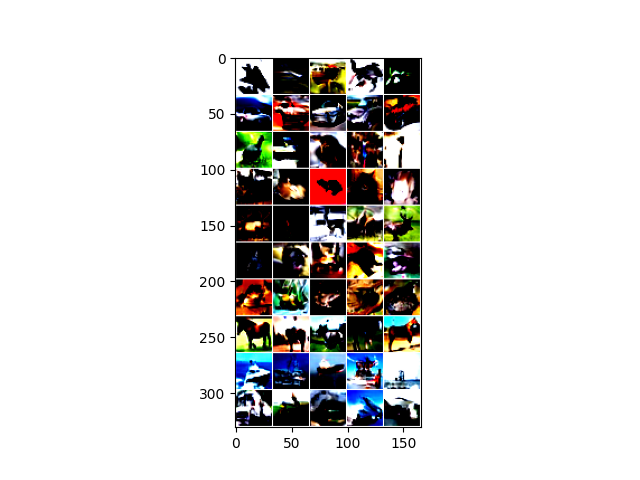

In [81]:
fpath = checkpoint_path / f'ITGAN_final_{dataset}_ConvNet_lrz0.001_exp{exp}.pt'
data_z = torch.load(fpath, map_location=device)
z_it = data_z['z_eff_all'].clone().detach()[idxs]
imgs_it = generate(z_it, labe)
grid_it = torchvision.utils.make_grid(imgs_it, nrow=samples_per_class, padding=1, pad_value=1)
grid_it = grid_it.permute(1, 2, 0).cpu().detach().numpy()
fig, ax = plt.subplots()
ax.imshow(grid_it)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


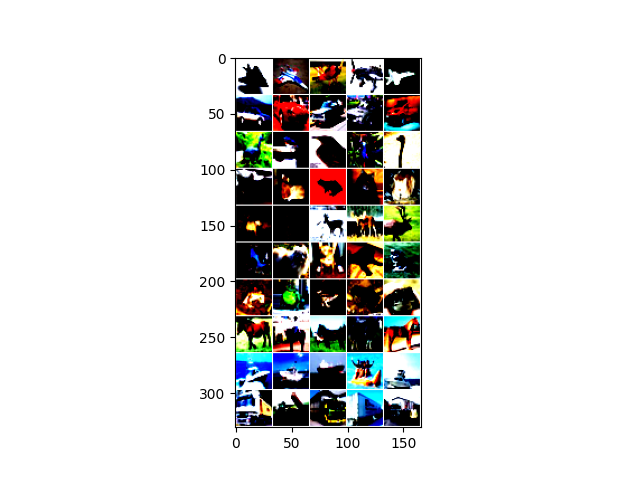

In [82]:
real_imgs = torch.stack([dst_train[i][0] for i in idxs])
grid_real = torchvision.utils.make_grid(real_imgs, nrow=samples_per_class, padding=1, pad_value=1)
grid_real = grid_real.permute(1, 2, 0).cpu().detach().numpy()
fig, ax = plt.subplots()

ax.imshow(grid_real)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Real samples')

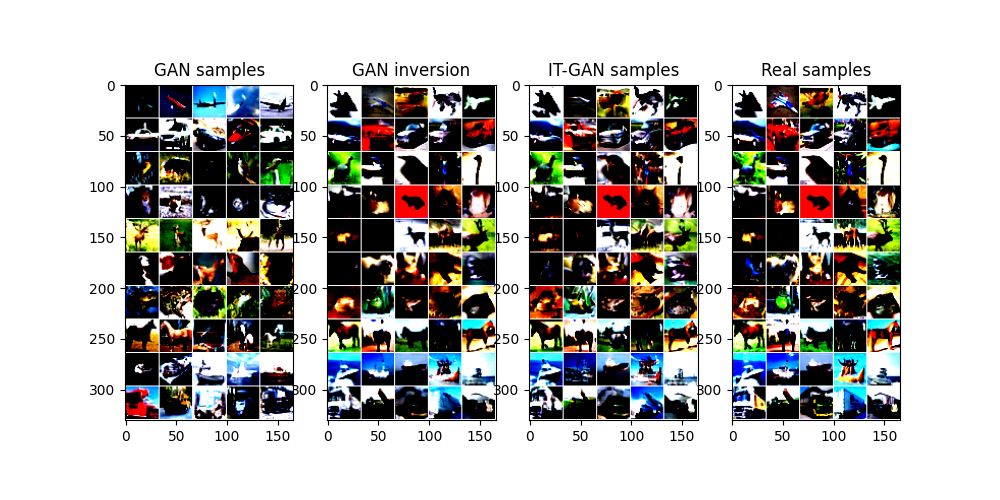

In [83]:
# plot all together

fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(grid_z)
ax[0].set_title('GAN samples')
ax[1].imshow(grid_inv)
ax[1].set_title('GAN inversion')
ax[2].imshow(grid_it)
ax[2].set_title('IT-GAN samples')
ax[3].imshow(grid_real)
ax[3].set_title('Real samples')


